### Imports

In [91]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import brown
from nltk.tag import untag
from nltk import DefaultTagger
from nltk import UnigramTagger
from nltk import NgramTagger
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pylab as pl
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords

nltk.download('brown')
nltk.download('universal_tagset')
nltk.download('stopwords')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\g.dib\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\g.dib\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\g.dib\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Loads

In [2]:
df_q = pd.read_csv("../Data/Questions.csv",encoding='latin')

## Syntactic Analysis

### Word Tagg

In [3]:
#Loading brown corpus
brown_news_tagged = brown.tagged_sents(tagset='universal')
brown_news_words = brown.tagged_words(tagset='universal')

In [4]:
brown_news_tagged

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

In [5]:
brown_train = brown_news_tagged[5000:]
brown_test = brown_news_tagged[:5000]

#### Unigrams

In [6]:
#Add allNouns to backoff
nn_tagger = DefaultTagger('NOUN')
#Train Tagger
ut2 = UnigramTagger(brown_train, backoff=nn_tagger)
print('Unigram tagger with backoff accuracy: %4.1f%%' % ( 100.0 * ut2.evaluate(brown_test)))

Unigram tagger with backoff accuracy: 94.5%


#### Bigrams

In [7]:
#ct2 = NgramTagger(2, brown_train, backoff=nn_tagger)
#print('Bigram tagger with backoff accuracy: %4.1f%%' % ( 100.0 * ct2.evaluate(brown_test)))

#### Trigrams

In [8]:
#ct3 = NgramTagger(3, brown_train, backoff=nn_tagger)
#print('Bigram tagger with backoff accuracy: %4.1f%%' % ( 100.0 * ct3.evaluate(brown_test)))

In [9]:
#try:
#    del ct2
#except:
#    print('non-existent')
#try:
#    del ct3
#except:
#    print('non-existent')

### DataPrep

In [10]:
df_q = df_q.loc[df_q.Score < 3000]
df_q.Title = df_q.Title.str.replace('?',' ?')
df_q.Title = df_q.Title.str.replace('.',' .')
df_q.Title = df_q.Title.str.replace(',',' ,')
df_q.Title = df_q.Title.str.replace('!',' !')
deletable = ['OwnerUserId','CreationDate','ClosedDate','Body']
for d in deletable:
    if d in df_q.columns:
        del df_q[d]

In [11]:
def getTaggedStr(t):
    x = ut2.tag(t.split(' '))
    l = []
    for item in x:
        l.append('('+item[0]+','+item[1]+')')
    return ' '.join(l)

In [12]:
#Tag All
df_q['TagTitle'] = df_q['Title'].apply(lambda x: getTaggedStr(x))
df_q[['TagTitle']].head()

,TagTitle
0,"(SQLStatement,NOUN) (.execute(),NOUN) (-,ADP) ..."
1,"(Good,ADJ) (branching,VERB) (and,CONJ) (mergin..."
2,"(ASP,NOUN) (.NET,NOUN) (Site,NOUN) (Maps,NOUN)"
3,"(Function,NOUN) (for,ADP) (creating,VERB) (col..."
4,"(Adding,NOUN) (scripting,NOUN) (functionality,..."


In [13]:
def countTag(tag,text):
    tags = ut2.tag(text.split(' '))
    count=0
    for item in tags:
        if(item[1]==tag):
            count+=1
    return count
def getFreq(n,text):
    f = n/len(text.split(' '))
    return f

In [14]:
df_q['freq_noun'] = df_q['Title'].apply(lambda x: getFreq(countTag('NOUN',x),x))
df_q['freq_adj'] = df_q['Title'].apply(lambda x: getFreq(countTag('ADJ',x),x))
df_q['freq_adv'] = df_q['Title'].apply(lambda x: getFreq(countTag('ADV',x),x))
df_q['freq_adp'] = df_q['Title'].apply(lambda x: getFreq(countTag('ADP',x),x))
df_q['freq_conj'] = df_q['Title'].apply(lambda x: getFreq(countTag('CONJ',x),x))
df_q['freq_pron'] = df_q['Title'].apply(lambda x: getFreq(countTag('PRON',x),x))
df_q['freq_prt'] = df_q['Title'].apply(lambda x: getFreq(countTag('PRT',x),x))
df_q['freq_pont'] = df_q['Title'].apply(lambda x: getFreq(countTag('.',x),x))
df_q['freq_det'] = df_q['Title'].apply(lambda x: getFreq(countTag('DET',x),x))
df_q['freq_num'] = df_q['Title'].apply(lambda x: getFreq(countTag('NUM',x),x))
df_q['freq_x'] = df_q['Title'].apply(lambda x: getFreq(countTag('X',x),x))
df_q.head()

,Id,Score,Title,TagTitle,freq_noun,freq_adj,freq_adv,freq_adp,freq_conj,freq_pron,freq_prt,freq_pont,freq_det,freq_num,freq_x
0,80,26,SQLStatement .execute() - multiple queries in ...,"(SQLStatement,NOUN) (.execute(),NOUN) (-,ADP) ...",0.500000,0.125,0.0,0.250,0.000,0.0,0.000000,0.000,0.0,0.125,0.0
1,90,144,Good branching and merging tutorials for Torto...,"(Good,ADJ) (branching,VERB) (and,CONJ) (mergin...",0.250000,0.125,0.0,0.125,0.125,0.0,0.000000,0.125,0.0,0.000,0.0
2,120,21,ASP .NET Site Maps,"(ASP,NOUN) (.NET,NOUN) (Site,NOUN) (Maps,NOUN)",1.000000,0.000,0.0,0.000,0.000,0.0,0.000000,0.000,0.0,0.000,0.0
3,180,53,Function for creating color wheels,"(Function,NOUN) (for,ADP) (creating,VERB) (col...",0.600000,0.000,0.0,0.200,0.000,0.0,0.000000,0.000,0.0,0.000,0.0
4,260,49,Adding scripting functionality to .NET applic...,"(Adding,NOUN) (scripting,NOUN) (functionality,...",0.857143,0.000,0.0,0.000,0.000,0.0,0.142857,0.000,0.0,0.000,0.0


In [15]:
x = df_q[['Score']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_q['n_score'] = pd.DataFrame(x_scaled)

In [16]:
df_t = pd.read_csv('../Data/Tags.csv',encoding='latin')
df_t['Tag'] = df_t['Tag'].astype(str)

In [17]:
df_n = df_t.groupby('Id')['Tag'].apply(lambda x: '~~'.join(x))
df_n = pd.DataFrame(df_n.reset_index())

In [18]:
df_n.head()

,Id,Tag
0,80,flex~~actionscript-3~~air
1,90,svn~~tortoisesvn~~branch~~branching-and-merging
2,120,sql~~asp.net~~sitemap
3,180,algorithm~~language-agnostic~~colors~~color-space
4,260,c#~~.net~~scripting~~compiler-construction


In [19]:
df_u = df_q.merge(df_t,on='Id',how='inner',suffixes=['',''])
df_u.Tag = df_u.Tag.str.lower()
df_u.Tag = df_u.Tag.str.replace('asp.net','.net')
df_u.loc[df_u.Id==120]

,Id,Score,Title,TagTitle,freq_noun,freq_adj,freq_adv,freq_adp,freq_conj,freq_pron,freq_prt,freq_pont,freq_det,freq_num,freq_x,n_score,Tag
7,120,21,ASP .NET Site Maps,"(ASP,NOUN) (.NET,NOUN) (Site,NOUN) (Maps,NOUN)",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.036015,sql
8,120,21,ASP .NET Site Maps,"(ASP,NOUN) (.NET,NOUN) (Site,NOUN) (Maps,NOUN)",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.036015,.net
9,120,21,ASP .NET Site Maps,"(ASP,NOUN) (.NET,NOUN) (Site,NOUN) (Maps,NOUN)",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.036015,sitemap


In [20]:
del df_n
del df_q

In [21]:
df_u.shape

(3750986, 17)

In [22]:
df_u.loc[(df_u.Score>50)].shape

(13409, 17)

In [23]:
#df_u = df_u.loc[df_u.Score > 50]

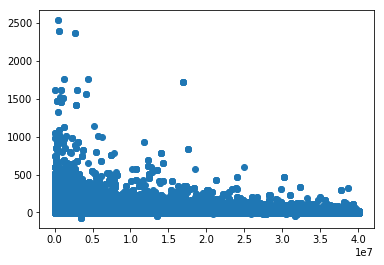

In [24]:
plt.scatter(df_u.Id,df_u.Score)

In [25]:
df_u.loc[(df_u.Score>2000)]

,Id,Score,Title,TagTitle,freq_noun,freq_adj,freq_adv,freq_adp,freq_conj,freq_pron,freq_prt,freq_pont,freq_det,freq_num,freq_x,n_score,Tag
16990,406230,2537,Regular expression to match line that doesn't ...,"(Regular,ADJ) (expression,NOUN) (to,PRT) (matc...",0.272727,0.090909,0.0,0.090909,0.0,0.0,0.090909,0.090909,0.090909,0.0,0.0,0.029119,regex
16991,406230,2537,Regular expression to match line that doesn't ...,"(Regular,ADJ) (expression,NOUN) (to,PRT) (matc...",0.272727,0.090909,0.0,0.090909,0.0,0.0,0.090909,0.090909,0.090909,0.0,0.0,0.029119,regex-negation
22642,520650,2399,Make an existing Git branch track a remote bra...,"(Make,VERB) (an,DET) (existing,VERB) (Git,VERB...",0.300000,0.100000,0.0,0.000000,0.0,0.0,0.000000,0.100000,0.200000,0.0,0.0,0.030268,git
22643,520650,2399,Make an existing Git branch track a remote bra...,"(Make,VERB) (an,DET) (existing,VERB) (Git,VERB...",0.300000,0.100000,0.0,0.000000,0.0,0.0,0.000000,0.100000,0.200000,0.0,0.0,0.030268,branch
22644,520650,2399,Make an existing Git branch track a remote bra...,"(Make,VERB) (an,DET) (existing,VERB) (Git,VERB...",0.300000,0.100000,0.0,0.000000,0.0,0.0,0.000000,0.100000,0.200000,0.0,0.0,0.030268,git-branch
165834,2669690,2363,Why does Google prepend while(1); to their JSO...,"(Why,ADV) (does,VERB) (Google,NOUN) (prepend,N...",0.500000,0.000000,0.1,0.000000,0.0,0.0,0.100000,0.100000,0.100000,0.0,0.0,0.029502,javascript
165835,2669690,2363,Why does Google prepend while(1); to their JSO...,"(Why,ADV) (does,VERB) (Google,NOUN) (prepend,N...",0.500000,0.000000,0.1,0.000000,0.0,0.0,0.100000,0.100000,0.100000,0.0,0.0,0.029502,ajax
165836,2669690,2363,Why does Google prepend while(1); to their JSO...,"(Why,ADV) (does,VERB) (Google,NOUN) (prepend,N...",0.500000,0.000000,0.1,0.000000,0.0,0.0,0.100000,0.100000,0.100000,0.0,0.0,0.029502,json


### NaiveBayes

In [26]:
if('TagTitle' in df_u.columns):
    del df_u['TagTitle']
df_u.head()

,Id,Score,Title,freq_noun,freq_adj,freq_adv,freq_adp,freq_conj,freq_pron,freq_prt,freq_pont,freq_det,freq_num,freq_x,n_score,Tag
0,80,26,SQLStatement .execute() - multiple queries in ...,0.50,0.125,0.0,0.250,0.000,0.0,0.0,0.000,0.0,0.125,0.0,0.037931,flex
1,80,26,SQLStatement .execute() - multiple queries in ...,0.50,0.125,0.0,0.250,0.000,0.0,0.0,0.000,0.0,0.125,0.0,0.037931,actionscript-3
2,80,26,SQLStatement .execute() - multiple queries in ...,0.50,0.125,0.0,0.250,0.000,0.0,0.0,0.000,0.0,0.125,0.0,0.037931,air
3,90,144,Good branching and merging tutorials for Torto...,0.25,0.125,0.0,0.125,0.125,0.0,0.0,0.125,0.0,0.000,0.0,0.083142,svn
4,90,144,Good branching and merging tutorials for Torto...,0.25,0.125,0.0,0.125,0.125,0.0,0.0,0.125,0.0,0.000,0.0,0.083142,tortoisesvn


In [27]:
df_u.shape

(3750986, 16)

In [28]:
new_df = df_u.groupby('Tag').count().reset_index().sort_values('Id',ascending=False)
categories = new_df.head(20)['Tag'].tolist()
print(categories)

['javascript', 'java', 'c#', 'php', 'android', 'jquery', 'python', 'html', '.net', 'c++', 'ios', 'mysql', 'css', 'sql', 'objective-c', 'ruby-on-rails', 'c', 'iphone', 'angularjs', 'arrays']


In [29]:
df_u['fake-index'] = df_u.index
dropables = []
for item in df_u.values:
    #print(item[16])
    if(item[15] not in categories):
        dropables.append(item[16])
del df_u['fake-index']

In [30]:
df_u = df_u.drop(dropables)

In [31]:
df_u.loc[df_u.Score>10]
backup = df_u.copy()
df_u = df_u.loc[df_u.Score>10]

In [32]:
df_clean = df_u[['Id','Title','Tag']]
df_clean.shape

(27465, 3)

In [33]:
backup.head()

,Id,Score,Title,freq_noun,freq_adj,freq_adv,freq_adp,freq_conj,freq_pron,freq_prt,freq_pont,freq_det,freq_num,freq_x,n_score,Tag
7,120,21,ASP .NET Site Maps,1.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.036015,sql
8,120,21,ASP .NET Site Maps,1.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.036015,.net
14,260,49,Adding scripting functionality to .NET applic...,0.857143,0.0,0.0,0.000000,0.0,0.000000,0.142857,0.000000,0.000000,0.0,0.0,0.046743,c#
15,260,49,Adding scripting functionality to .NET applic...,0.857143,0.0,0.0,0.000000,0.0,0.000000,0.142857,0.000000,0.000000,0.0,0.0,0.046743,.net
18,330,29,Should I use nested classes in this case ?,0.333333,0.0,0.0,0.111111,0.0,0.111111,0.000000,0.111111,0.111111,0.0,0.0,0.039080,c++


In [34]:
df_n = df_clean.groupby('Id')['Tag'].apply(lambda x: '~~'.join(x))
df_n = pd.DataFrame(df_n.reset_index())
df_n.Tag = df_n.Tag.apply(lambda x: x+'~~')
df_n.head(10)

,Id,Tag
0,120,sql~~.net~~
1,260,c#~~.net~~
2,330,c++~~
3,470,.net~~
4,650,c#~~
5,930,c#~~
6,1010,c#~~.net~~
7,1040,c#~~
8,1300,.net~~
9,1760,c#~~.net~~


In [35]:
def possuiTag(tag,Ids):
    l = []
    for Id in Ids:
        d = df_n.loc[df_n.Id==Id]
        if(tag+'~~' in d['Tag'].tolist()[0]):
            l.append(1)
        else:
            l.append(0)
    return l

In [36]:
df_clean.head()

,Id,Title,Tag
7,120,ASP .NET Site Maps,sql
8,120,ASP .NET Site Maps,.net
14,260,Adding scripting functionality to .NET applic...,c#
15,260,Adding scripting functionality to .NET applic...,.net
18,330,Should I use nested classes in this case ?,c++


In [37]:
for c in categories:
    df_clean[c] = possuiTag(c,df_clean['Id'].tolist())

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [38]:
df_clean.head(2)

,Id,Title,Tag,javascript,java,c#,php,android,jquery,python,...,ios,mysql,css,sql,objective-c,ruby-on-rails,c,iphone,angularjs,arrays
7,120,ASP .NET Site Maps,sql,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
8,120,ASP .NET Site Maps,.net,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [39]:
del df_clean['Tag']

In [40]:
df_clean = df_clean.groupby('Id').max().reset_index()
df_clean = df_clean.drop_duplicates()

In [41]:
print(df_clean.shape)
df_clean.head(5)

(22116, 22)


,Id,Title,javascript,java,c#,php,android,jquery,python,html,...,ios,mysql,css,sql,objective-c,ruby-on-rails,c,iphone,angularjs,arrays
0,120,ASP .NET Site Maps,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,260,Adding scripting functionality to .NET applic...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,330,Should I use nested classes in this case ?,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,470,Homegrown consumption of web services,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,650,Automatically update version number,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
stop_words = set(stopwords.words('english'))
def getPipe():
    NB_pipeline = Pipeline([
                    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                    ('clf', OneVsRestClassifier(MultinomialNB(
                        fit_prior=True, class_prior=None,))),
                ])
    return(NB_pipeline)

In [43]:
train, test = train_test_split(df_clean, random_state=42, test_size=0.33, shuffle=True)
X_train = train.Title
X_test = test.Title

In [44]:
del df_clean['Id']

In [45]:
X_train.shape

(14817,)

In [46]:
df_clean.groupby('java').count()

,Title,javascript,c#,php,android,jquery,python,html,.net,c++,ios,mysql,css,sql,objective-c,ruby-on-rails,c,iphone,angularjs,arrays
java,,,,,,,,,,,,,,,,,,,,
0,19065,19065,19065,19065,19065,19065,19065,19065,19065,19065,19065,19065,19065,19065,19065,19065,19065,19065,19065,19065
1,3051,3051,3051,3051,3051,3051,3051,3051,3051,3051,3051,3051,3051,3051,3051,3051,3051,3051,3051,3051


In [48]:
list_of_models={}
for category in categories:
    df_temp = df_clean.copy()
    df_temp = df_temp.append(df_temp.loc[df_temp[category]==1])
    auc = 0
    print('... Processing {}'.format(category))
    while(auc<0.7):
        df_temp = df_temp.append(df_temp.loc[df_temp[category]==1])
        train, test = train_test_split(df_temp, random_state=42, test_size=0.33, shuffle=True)
        X_train = train.Title
        X_test = test.Title
        x = getPipe()
        # train the model using X_dtm & y
        list_of_models[category] = x.fit(X_train, train[category],)
        # compute the testing accuracy
        prediction = x.predict(X_test)
        auc = roc_auc_score(test[category], prediction)
        #print(df_temp.shape,'-',auc)
    print('Test auc roc score is ',(roc_auc_score(test[category], prediction)))
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing javascript
Test auc roc score is  0.8814046747001061
Test accuracy is 0.9025462726250127
... Processing java
Test auc roc score is  0.8885088998485645
Test accuracy is 0.899505766062603
... Processing c#
Test auc roc score is  0.8438427267405565
Test accuracy is 0.8607816449543069
... Processing php
Test auc roc score is  0.8048152977666162
Test accuracy is 0.9237268246890401
... Processing android
Test auc roc score is  0.9324978645366354
Test accuracy is 0.9453833470733718
... Processing jquery
Test auc roc score is  0.8222429859876453
Test accuracy is 0.9255955873723741
... Processing python
Test auc roc score is  0.90921420110167
Test accuracy is 0.9441220717816462
... Processing html
Test auc roc score is  0.8880687117253778
Test accuracy is 0.9209863588667366
... Processing .net
Test auc roc score is  0.7675860524317561
Test accuracy is 0.8742806551571491
... Processing c++
Test auc roc score is  0.8566744609248292
Test accuracy is 0.9102076312642678
... Processing

In [162]:
predicts = pd.DataFrame(list_of_models['java'].predict_proba(X_test))
predicts[1].apply(lambda x : x>0.2).astype(int)
categories

['javascript',
 'java',
 'c#',
 'php',
 'android',
 'jquery',
 'python',
 'html',
 '.net',
 'c++',
 'ios',
 'mysql',
 'css',
 'sql',
 'objective-c',
 'ruby-on-rails',
 'c',
 'iphone',
 'angularjs',
 'arrays']

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline,

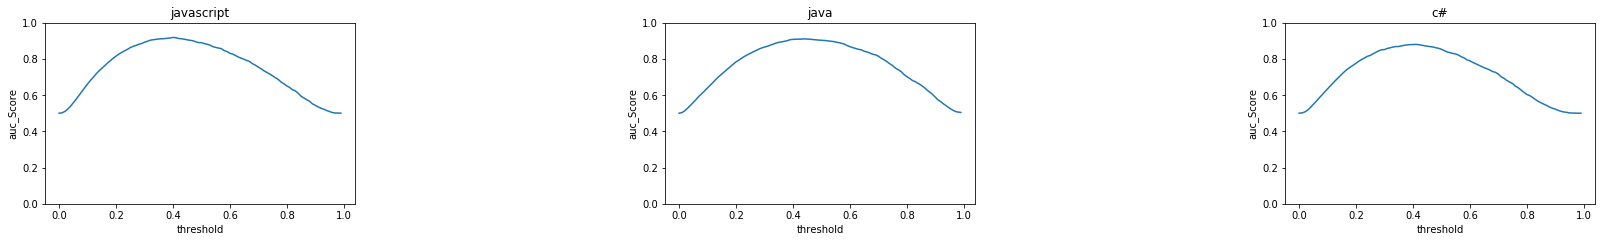

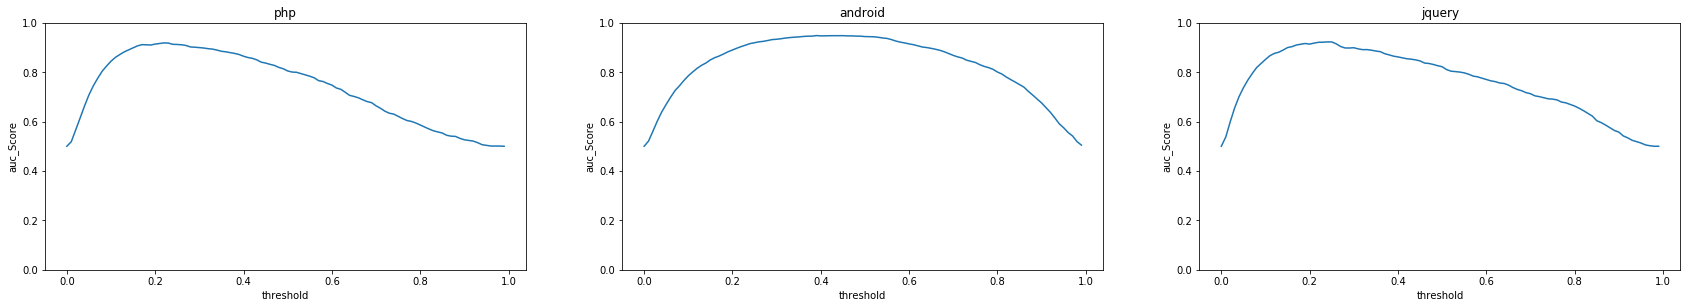

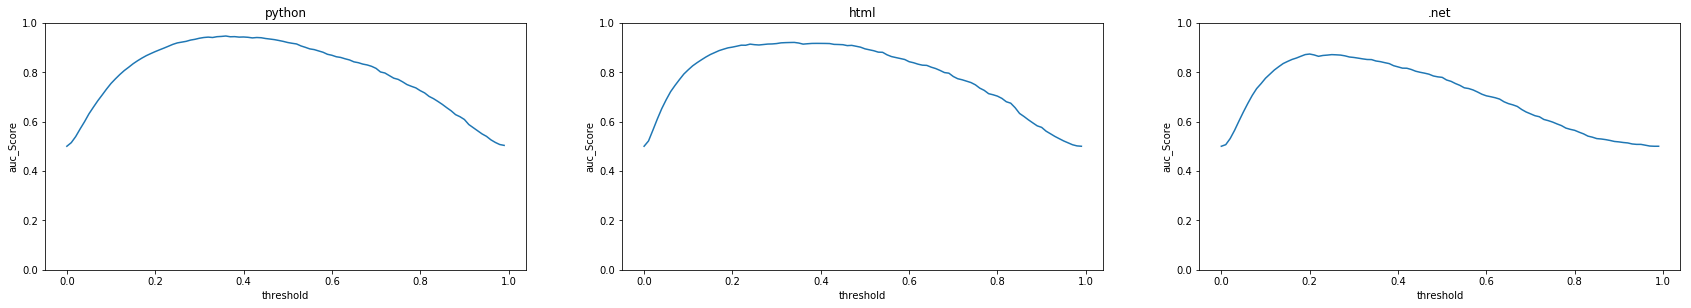

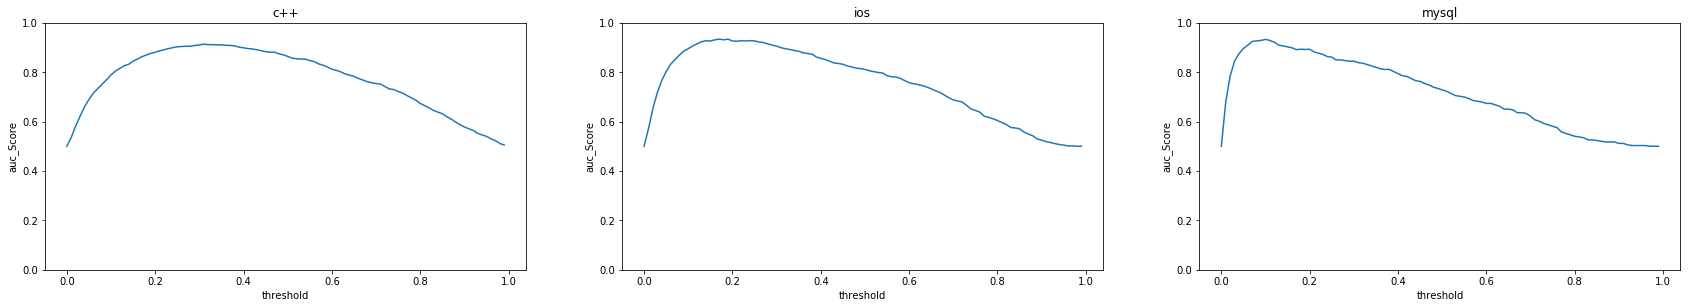

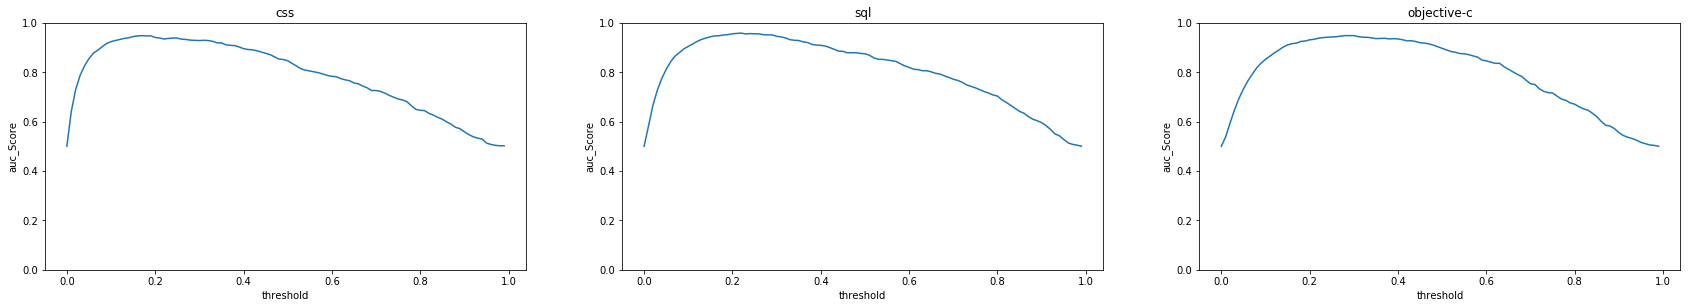

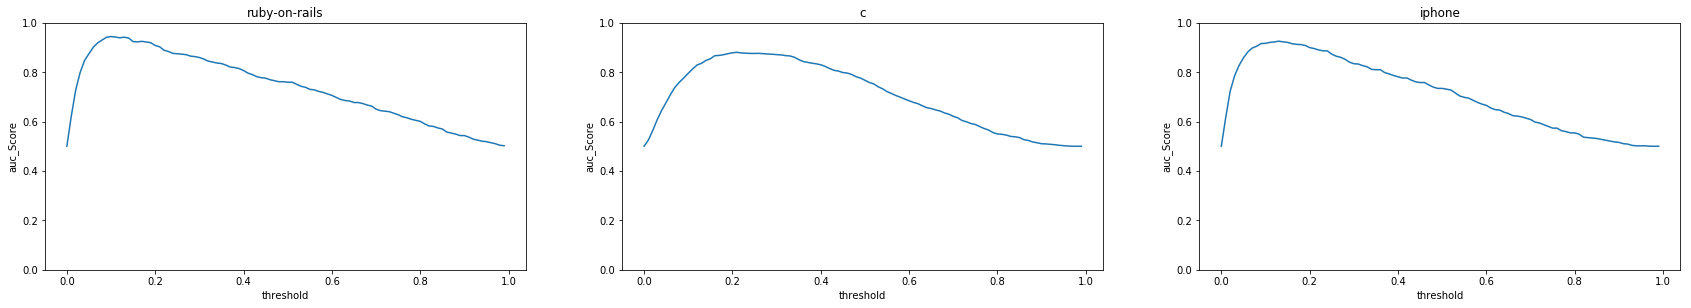

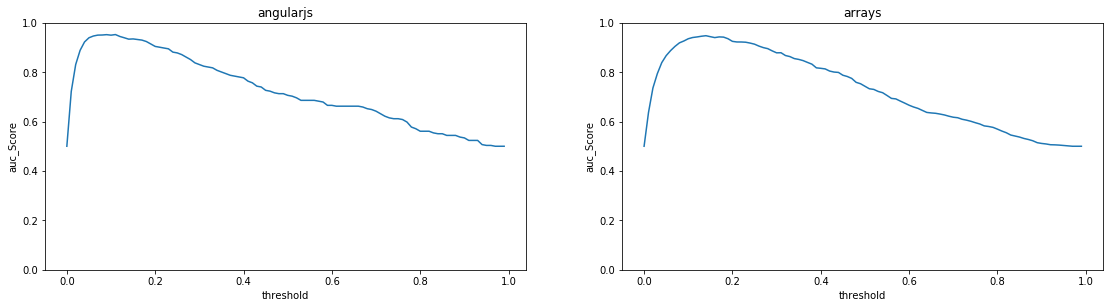

In [184]:
temps = 251
cont=0
fig=plt.figure(figsize=(50,10))
plt.subplots_adjust(hspace = 1,wspace=1)
max_aucs = {}

for c in categories:
    m=(0,0)
    auc_Scores = []
    predicts = pd.DataFrame(list_of_models[c].predict_proba(X_test))
    for i in np.arange(0, 1, 0.01):
        temp = predicts[1].apply(lambda x : x>i).astype(int)
        r = roc_auc_score(test[c],temp)
        auc_Scores.append(r)
        if(r>=m[0]):
            #print(m[0],r)
            m = (r,i)
    max_aucs[c]=m
    ax1 = fig.add_subplot(temps)
    temps +=1
    if(temps%10==0):
        temps+=1
    ax1.set_ylim(0,1)
    ax1.set_title(c)
    ax1.set_ylabel('auc_Score')
    ax1.set_xlabel('threshold')
    ax1.plot(np.arange(0, 1, 0.01),auc_Scores) 
    cont+=1
    if(cont>2):
        cont=0
        temps=251
        fig.show()
        fig=plt.figure(figsize=(50,10))

In [183]:
max_aucs

{'javascript': (0.9179105379671425, 0.4),
 'java': (0.9103622207640208, 0.44),
 'c#': (0.879725694392341, 0.41000000000000003),
 'php': (0.9183339534972474, 0.22),
 'android': (0.9478791636039772, 0.39),
 'jquery': (0.9222671764013417, 0.24),
 'python': (0.9461595015392484, 0.36),
 'html': (0.9202405300609314, 0.34),
 '.net': (0.8732434595516477, 0.2),
 'c++': (0.9130317621634693, 0.31),
 'ios': (0.9335083870377987, 0.17),
 'mysql': (0.9325807429057732, 0.1),
 'css': (0.9476817655462956, 0.17),
 'sql': (0.9580659471051529, 0.22),
 'objective-c': (0.9478580190957752, 0.28),
 'ruby-on-rails': (0.944062026207494, 0.1),
 'c': (0.8802596743039829, 0.21),
 'iphone': (0.9253471372794615, 0.13),
 'angularjs': (0.9520239861063714, 0.11),
 'arrays': (0.9473822581703523, 0.14)}

In [ ]:
df_clean.groupby('c++').count()

In [ ]:
df_clean.to_csv('../Data/cleanDF.csv',encoding='latin')

In [ ]:
backup.head()

In [ ]:
def Predicts(title):
    predicts = {}
    for m in list_of_models.items():
        predicts[m[0]] = m[1].predict([title])[0]
    return predicts

In [ ]:
print(Predicts('SELECT WITH MULTIPLE CONDITIONS'))

In [ ]:
print(Predicts('SYSTEM.OUT.PRINTLN not working'))

In [ ]:
print(Predicts('How to start a thread pool?'))

In [ ]:
print(Predicts('How to connect ASP.net to SQL database'))

In [ ]:
print(Predicts('How to print in .NET application'))

In [ ]:
print(Predicts('How to print with Ruby?'))

### Export Pickle Model

In [ ]:
import pickle

In [ ]:
for m in list_of_models.items():
    filename = './pickle/' + m[0] + '.nav'
    #print(filename)
    file = open(filename,"w+")
    pickle.dump(m[1],open(filename,'wb'))

#### Teste

In [ ]:
model = pickle.load(open('./pickle/java.nav','rb'))
model.predict(['System.out.println not working'])[0]

### Using KMeans to define 'Good Questions'

In [ ]:
df_q = df_q.sort_values('n_score',ascending=False)
df_q = df_q.dropna()

In [ ]:
df_cluster = df_q.copy()
del df_cluster['Title']
del df_cluster['Score']
del df_cluster['Id']
del df_cluster['TagTitle']

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_cluster)

In [ ]:
#Visualizar com PCA
pca = PCA(n_components=5).fit(df_cluster)
pca_2d = pca.transform(df_cluster)

In [ ]:
pl.scatter(pca_2d[:,0],pca_2d[:,1],c='black')
pl.show()

In [ ]:
def ehBom(x):
    if(x>0.6):
        return 1
    else:
        return 0
df_cluster['flag_bom'] = df_cluster.n_score.apply(lambda x: ehBom(x))

In [ ]:
#df_cluster.flag_bom
#kmeans.labels_

In [ ]:
df_cluster['cluster'] = pd.Series(kmeans.labels_)

In [ ]:
df_cluster.groupby('cluster').mean()